In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import mode
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from datetime import datetime,timedelta
from lightgbm import LGBMClassifier
from itertools import product
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
quote = pd.read_csv("quote.csv")
trade = pd.read_csv("trade.csv")

# Exploratory Data Analysis

In [3]:
quote["time"] = pd.to_datetime(quote['recv_time'].values/1e6, utc=True, unit='s').tz_convert("Asia/Shanghai")
trade["time"] = pd.to_datetime(trade['recv_time'].values/1e6, utc=True, unit='s').tz_convert("Asia/Shanghai")

In [4]:
quote.isnull().sum()

recv_time    0
symbol       0
bid_price    0
bid_size     0
ask_price    0
ask_size     0
time         0
dtype: int64

In [5]:
trade.isnull().sum()

recv_time      0
symbol         0
trade_price    0
trade_qty      0
time           0
dtype: int64

In [6]:
quote.isna().sum()

recv_time    0
symbol       0
bid_price    0
bid_size     0
ask_price    0
ask_size     0
time         0
dtype: int64

In [7]:
trade.isna().sum()

recv_time      0
symbol         0
trade_price    0
trade_qty      0
time           0
dtype: int64

In [8]:
quote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1312745 entries, 0 to 1312744
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype                        
---  ------     --------------    -----                        
 0   recv_time  1312745 non-null  int64                        
 1   symbol     1312745 non-null  object                       
 2   bid_price  1312745 non-null  float64                      
 3   bid_size   1312745 non-null  int64                        
 4   ask_price  1312745 non-null  float64                      
 5   ask_size   1312745 non-null  int64                        
 6   time       1312745 non-null  datetime64[ns, Asia/Shanghai]
dtypes: datetime64[ns, Asia/Shanghai](1), float64(2), int64(3), object(1)
memory usage: 70.1+ MB


In [9]:
trade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1158474 entries, 0 to 1158473
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype                        
---  ------       --------------    -----                        
 0   recv_time    1158474 non-null  int64                        
 1   symbol       1158474 non-null  object                       
 2   trade_price  1158474 non-null  float64                      
 3   trade_qty    1158474 non-null  int64                        
 4   time         1158474 non-null  datetime64[ns, Asia/Shanghai]
dtypes: datetime64[ns, Asia/Shanghai](1), float64(1), int64(2), object(1)
memory usage: 44.2+ MB


In [10]:
quote.describe()

,recv_time,bid_price,bid_size,ask_price,ask_size
count,1.312745e+06,1.312745e+06,1.312745e+06,1.312745e+06,1.312745e+06
mean,1.602215e+15,7.658014e+03,5.158142e+04,7.657961e+03,8.344331e+04
std,6.905859e+09,8.727901e+06,1.854745e+05,8.727901e+06,4.110124e+05
min,1.602206e+15,0.000000e+00,-1.000000e+05,0.000000e+00,-1.000000e+05
25%,1.602209e+15,1.067000e+01,1.300000e+03,1.068000e+01,1.200000e+03
50%,1.602212e+15,1.604000e+01,6.500000e+03,1.603000e+01,5.900000e+03
75%,1.602222e+15,5.642000e+01,2.766700e+04,5.631000e+01,2.800000e+04
max,1.602227e+15,1.000000e+10,3.864600e+06,1.000000e+10,6.773600e+06


In [11]:
trade.describe()

,recv_time,trade_price,trade_qty
count,1.158474e+06,1.158474e+06,1.158474e+06
mean,1.602214e+15,1.285126e+02,8.741242e+04
std,6.929418e+09,9.290882e+04,9.290880e+07
min,1.602207e+15,-1.000000e+05,-1.000000e+05
25%,1.602208e+15,1.074000e+01,1.000000e+02
50%,1.602211e+15,2.059000e+01,3.000000e+02
75%,1.602222e+15,5.669000e+01,8.000000e+02
max,1.602227e+15,1.000000e+08,1.000000e+11


In [12]:
quote.drop(quote[quote.ask_price>1e3].index,inplace=True)
quote.drop(quote[quote.bid_price>1e3].index,inplace=True)

In [13]:
trade.drop(trade[trade.trade_price>1e3].index,inplace=True) 
trade.drop(trade[trade.trade_qty>1e6].index,inplace=True)

In [14]:
quote.describe()

,recv_time,bid_price,bid_size,ask_price,ask_size
count,1.312743e+06,1.312743e+06,1.312743e+06,1.312743e+06,1.312743e+06
mean,1.602215e+15,4.038847e+01,5.158148e+04,4.033548e+01,8.344343e+04
std,6.905858e+09,5.477414e+01,1.854746e+05,5.479595e+01,4.110127e+05
min,1.602206e+15,0.000000e+00,-1.000000e+05,0.000000e+00,-1.000000e+05
25%,1.602209e+15,1.067000e+01,1.300000e+03,1.068000e+01,1.200000e+03
50%,1.602212e+15,1.604000e+01,6.500000e+03,1.603000e+01,5.900000e+03
75%,1.602222e+15,5.642000e+01,2.766950e+04,5.631000e+01,2.800000e+04
max,1.602227e+15,2.295500e+02,3.864600e+06,2.295600e+02,6.773600e+06


In [15]:
trade.describe()

,recv_time,trade_price,trade_qty
count,1.158472e+06,1.158472e+06,1.158472e+06
mean,1.602214e+15,4.219221e+01,1.091967e+03
std,6.929416e+09,1.091849e+02,5.239143e+03
min,1.602207e+15,-1.000000e+05,-1.000000e+05
25%,1.602208e+15,1.074000e+01,1.000000e+02
50%,1.602211e+15,2.059000e+01,3.000000e+02
75%,1.602222e+15,5.669000e+01,8.000000e+02
max,1.602227e+15,2.295500e+02,8.726000e+05


In [16]:
quote["hm"] = pd.to_datetime((quote['recv_time']//1e6+3600*8).astype(int),unit='s')
trade["hm"] = pd.to_datetime((trade['recv_time']//1e6+3600*8).astype(int),unit='s')

# Machine Learning Prediction
## Target Variable and Feature Engineering

In [59]:
data = pd.merge(trade,quote,on=["recv_time","symbol","time"],how='inner')
data["mid_price"]=(data["bid_price"]+data["ask_price"])/2

In [60]:
data_temp = data[["time","mid_price","symbol"]].copy()
data_temp.time=data_temp["time"]-pd.Timedelta("10s")
data_temp.rename(columns={"mid_price":"future_mid_price"},inplace=True)

In [61]:
data = pd.merge_asof(data,data_temp,on = "time", by = "symbol",tolerance=pd.Timedelta("500ms"))
data.dropna(inplace=True)

In [62]:
data["target"] = np.log(data["future_mid_price"]/data["mid_price"])
data["target_direction"] =  np.where(data['target']>0,1,0)

In [63]:
import gc
del data_temp
gc.collect()

0

In [64]:
class feature_engineering:
    diff_window = [1,32,64]
    second_wondw = [1,5,10]
    max_lag = 10
    @staticmethod
    def spread(data):
        data["spread"] = data["ask_price"]-data["bid_price"]
    @staticmethod
    def qty_diff_sum(data):
        data["qty_sum"] = data["ask_size"]+data["bid_size"]
        data["qty_diff"] = data["ask_size"]-data["bid_size"]
    @staticmethod
    def trade_price_feature(data):
        data["trade_price_compare"]=0
        data.loc[data.trade_price<=data.bid_price,"trade_price_compare"] = -1
        data.loc[data.trade_price>=data.ask_price,"trade_price_compare"] = 1
    @staticmethod
    def diff(data,cols,windows):
        for window in windows:
            for i in cols:
                name = f"{i}_diff_{window}"
                data[name] = data.groupby("symbol")[i].transform(lambda x: x-x.shift(window))
    @staticmethod
    def up_down(data,windows):
        for window in windows:
            data[f"up_down_{window}"]=0
            data.loc[data[f"bid_price_diff_{window}"]<0,f"up_down_{window}"]=-1
            data.loc[data[f"ask_price_diff_{window}"]>0,f"up_down_{window}"]=1
    @staticmethod
    def lag(data, col, window):
        name = f"{col}_lag_{window}"
        data[name]=data.groupby("symbol")[col].transform(lambda x: x.shift(window))
    @staticmethod
    def rolling_data(data, col, window, how):
        name = f"{col}_rolling_{how}_{window}"
        if how == "sum":
            data[name] = data.groupby("symbol")[col].transform(lambda x: x.rolling(window = window,min_periods=1).sum())
        elif how == "mean":
            data[name] = data.groupby("symbol")[col].transform(lambda x: x.rolling(window = window,min_periods=1).mean())
        elif how == "max":
            data[name] = data.groupby("symbol")[col].transform(lambda x: x.rolling(window = window,min_periods=1).max())
        elif how == "min":
            data[name] = data.groupby("symbol")[col].transform(lambda x: x.rolling(window = window,min_periods=1).min())
        elif how == "median":
            data[name] = data.groupby("symbol")[col].transform(lambda x: x.rolling(window = window,min_periods=1).median())
        elif how == "mode":
            data[name] = data.groupby("symbol")[col].transform(lambda x: x.rolling(window = window,min_periods=1).apply(lambda x :mode(x)[0]))

    @classmethod
    def basic(cls,data,exp):
        data = data.copy()
        cls.spread(data)
        cls.qty_diff_sum(data)
        cls.trade_price_feature(data)
        cols = set(data.columns)-exp
        cls.diff(data,cols,cls.diff_window)
        cls.up_down(data,cls.diff_window)
        return data

    @classmethod
    def lag_rolling_feature(cls,data,exp):
        data = data.copy()
        up_down = {f"up_down_{window}" for window in cls.diff_window}
        rolling_cols=set(data.columns)-exp-{"trade_price_compare"}-up_down
        for col in rolling_cols:
            for lag in range(1,cls.max_lag+1):
                cls.lag(data,col,lag)
                
        data.reset_index(inplace=True)
        data.index = data.time
        data.drop(columns="time",inplace=True)
        
        for col in rolling_cols:
            for window in cls.second_wondw:
                window = f"{window}s"
                cls.rolling_data(data,col,window,"sum")
                cls.rolling_data(data,col,window,"mean")
                cls.rolling_data(data,col,window,"max")
                cls.rolling_data(data,col,window,"min")
                cls.rolling_data(data,col,window,"median")
        for col in {"trade_price_compare"}.union(up_down):
            for window in cls.second_wondw:
                window = f"{window}s"
                cls.rolling_data(data,col,window,"mode")
        return data

class feature_selection:
    @classmethod
    def correlation_filter(cls,data,threshold = 0.99):
        data = data.copy()
        index2col = {i: col for i, col in enumerate(data.columns)}
        corr_matrix = np.triu(np.corrcoef(feature.values,rowvar=False),k=1)
        select = list(set(np.array(list(set(zip(*np.where(corr_matrix>threshold)))))[:,0]))
        remove_cols = list(map(lambda x:index2col[x], select))
        data.drop(columns=remove_cols,inplace=True)
        print(remove_cols)
        return data

    @classmethod
    def select(cls, train_x, train_y, top_perc=0.90,iter_time=5):
        feature_imp = np.zeros((train_x.shape[1], iter_time))
        for i in range(0, iter_time):
            rf = RandomForestClassifier(n_estimators=10, max_depth=8)
            rf.fit(train_x, train_y)
            feature_imp[:,i] = rf.feature_importances_
        score =  np.mean(feature_imp,axis=1)
        feature_select = np.where(score>np.quantile(score,top_perc))[0]
        return feature_select


class lightgbm_model:
    lgbm_paramgrid = {
        'learning_rate': np.arange(0.0005, 0.0015, 0.0002),
        'n_estimators': range(800, 2000, 200),
        'max_depth': [3, 4],
        'colsample_bytree': np.arange(0.2, 0.5, 0.15),
        'reg_alpha': [1],
        'reg_lambda': [1]
    }

    @classmethod
    def lightgbm(cls, x, y):
        best_param = cls.GS_tune_lgbm(x, y)
        lightgbm = LGBMClassifier(**best_param)
        lightgbm.fit(x, y)

        return lightgbm

    @classmethod
    def GS_tune_lgbm(cls, x, y):
        tuner = GridSearchCV(
            estimator=LGBMClassifier(),
            param_grid=cls.lgbm_paramgrid,
            scoring="accuracy",
            cv=TimeSeriesSplit(n_splits=3),
            verbose=1,
            n_jobs=-1,
        )
        tuner.fit(x, y)
        return tuner.best_params_

In [68]:
target =  data['target_direction'].copy()

In [69]:
exp={"recv_time","target_direction","target","future_mid_price"}
feature = data[set(data.columns)-exp].copy()
feature.sort_values("time",inplace=True)
exp = {"time","symbol"}

In [70]:
feature = feature_engineering.basic(feature,exp)
feature.dropna(inplace=True)
head = feature[["time","symbol"]].copy()
feature.drop(columns=["time","symbol"],inplace=True)
target = target[feature.index]

In [71]:
print("filtered out feature")
feature = feature_selection.correlation_filter(feature)
feature[["time","symbol"]] = head

filtered out feature
['ask_price', 'mid_price', 'ask_price_diff_64', 'bid_price', 'ask_price_diff_1', 'mid_price_diff_1', 'ask_price_diff_32', 'mid_price_diff_32']


In [ ]:
feature = feature_engineering.lag_rolling_feature(feature,exp)

In [73]:
feature.dropna(inplace=True)
feature.drop(columns="symbol",inplace=True)

In [74]:
target = target[feature["index"]]
feature.drop(columns="index",inplace=True)

In [75]:
del head, exp
gc.collect()

0

In [76]:
print("filtered out feature")
feature = feature_selection.correlation_filter(feature)

filtered out feature
['trade_price_rolling_min_1s', 'trade_price_rolling_median_1s', 'ask_size', 'trade_price', 'trade_price_rolling_max_5s', 'trade_price_rolling_min_5s', 'trade_price_rolling_mean_5s', 'qty_sum', 'spread', 'trade_price_rolling_median_5s', 'trade_price_rolling_mean_10s', 'spread_diff_1', 'trade_price_rolling_max_10s', 'trade_price_rolling_min_10s', 'spread_diff_32', 'mid_price_diff_64', 'spread_diff_64', 'trade_qty_rolling_max_5s', 'trade_qty_rolling_max_10s', 'bid_price_diff_64_rolling_mean_1s', 'spread_diff_32_rolling_mean_1s', 'spread_diff_32_rolling_max_1s', 'spread_diff_32_rolling_min_1s', 'spread_diff_32_rolling_mean_5s', 'spread_diff_32_rolling_mean_10s', 'spread_diff_32_rolling_min_10s', 'qty_sum_diff_32_rolling_mean_1s', 'trade_price_lag_1', 'trade_price_lag_2', 'trade_price_lag_3', 'trade_price_lag_4', 'trade_price_lag_5', 'trade_price_lag_6', 'trade_price_lag_7', 'trade_price_lag_8', 'trade_price_lag_9', 'trade_price_lag_10', 'qty_sum_diff_64_rolling_mean_1s

## Data Normalization and Feature Selection

In [78]:
threshold=int(feature.shape[0]*0.6)
train_x = feature.iloc[:threshold,:].values
test_x = feature.iloc[threshold:,:].values
train_y = target.iloc[:threshold].values
test_y = target.iloc[threshold:].values

In [79]:
scaler = RobustScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [80]:
feature_select = feature_selection.select(train_x,train_y)

In [81]:
train_x=train_x[:,feature_select]
test_x=test_x[:,feature_select]

## Model Training (LightGBM)

In [84]:
model = lightgbm_model.lightgbm(train_x,train_y)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


## Model testing (LightGBM)

In [85]:
lgbm_predict = model.predict(test_x)

In [88]:
print("Accuracy")
(lgbm_predict == test_y).sum()/test_y.shape[0]

Accuracy


0.7116528297387131

In [90]:
print("AUC score")
lgbm_proba = model.predict_proba(test_x)[:,1]
roc_auc_score(test_y,lgbm_proba)

AUC score


0.7453023415122542

In [91]:
res = []
res_n=[]
for i in np.arange(0.1,0.78,0.01):
    lgbm_predict = np.where(lgbm_proba>i,1,0)
    pos_res = test_y[np.where(lgbm_predict==1)[0]]
    res.append((pos_res==1).sum()/pos_res.shape[0])
    res_n.append(pos_res.shape[0]/test_y.shape[0])

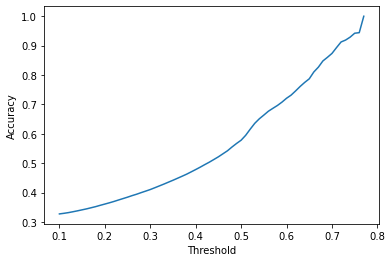

In [102]:
plt.plot(np.arange(0.1,0.78,0.01),res)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.show()

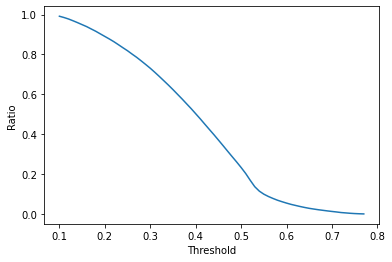

In [103]:
plt.plot(np.arange(0.1,0.78,0.01),res_n)
plt.xlabel("Threshold")
plt.ylabel("Ratio")
plt.show()

In [94]:
lgbm_predict = np.where(lgbm_proba>0.52,1,0)
pos_res = test_y[np.where(lgbm_predict==1)[0]]
print((pos_res==1).sum()/pos_res.shape[0])
print(pos_res.shape[0]/test_y.shape[0])

0.6159024905394702
0.169366979177535


In [104]:
(test_y==1).sum()/test_y.shape[0]

0.32491690390663425

## Model Training (MLP)

In [95]:
import torch
import torch.nn as nn
import transformers
import time

In [96]:
# Function and classes define

# MLP Class
class MLPBlock(nn.Module):
    def __init__(self,n_input,n_output,ifBatchnorm):
        super(MLPBlock, self).__init__()
        self.linear=nn.Linear(n_input,n_output)
        self.relu=nn.functional.hardtanh
        self.ifBatchnorm=ifBatchnorm
        if ifBatchnorm:
            self.Batchnorm=nn.BatchNorm1d(n_output)
    def forward(self, x):
        out=self.linear(x)
        if self.ifBatchnorm:
            out=self.Batchnorm(out)
        out=self.relu(out,min_val=-1,max_val=1)
        return out
class MLPModel(nn.Module):
    def __init__(self,inputs,ifBatchnorm=True):
        super(MLPModel,self).__init__()
        layers=[]
        num_layers=len(inputs)-1
        for i in range(num_layers):
            if i != num_layers-1:
                layers+=[MLPBlock(inputs[i],inputs[i+1],ifBatchnorm)]
            else:
                self.lastLinear=nn.Linear(inputs[i],inputs[i+1])
        self.network = nn.Sequential(*layers)
    def forward(self,x):
        out=self.network(x)
        out=self.lastLinear(out)
        return out

# Data loader
class n_window_indexer:

    def __init__( self, x_tup, window_len = 32 ):
        self.idxes = {}

        self.idxes['train'], self.idxes['test'], self.idxes['valid'] = np.arange(x_tup[0].shape[0]),\
            np.arange(x_tup[1].shape[0]), np.arange(x_tup[2].shape[0])

        self.window = window_len
        self.n_lookback = self.window

        # maximum len
        self.max_len = len(self.idxes['train']) + len(self.idxes['test']) + \
            len(self.idxes['valid'])

        self.init_lookbacks()

    def init_lookbacks( self ):
        v = []
        for i in range(self.n_lookback + 1):
            prev_n = self.n_lookback - i

            if prev_n > 0:
                this_v = np.hstack((np.ones((prev_n, 1)).reshape(-1,) * i,  np.arange(i, -1, -1).reshape(-1,)))
            else:
                this_v = np.arange(i, -1, -1).reshape(-1,)

            v.append(this_v)
        self.back_inds = np.vstack( v )


        _lookback = np.ones(self.max_len) * self.n_lookback
        _lookback[:self.n_lookback] = np.arange(0, self.n_lookback)

        self.full_lookback = _lookback.astype(int)

    def get_len( self, data_type = 'train', batch_size = 1024):
        the_n = self.idxes[data_type].shape[0]
        the_n_batch = int(np.ceil(the_n / batch_size))

        return the_n_batch

    def iter_data( self, batch_size = 1024, data_type = 'train', shuffle=True, seed = 0, return_ratio = 1.0):

        raw_inds = self.idxes[data_type].copy()
        inds = raw_inds
        self.n = inds.shape[0]
        self.n_batches = int( np.ceil( self.n / batch_size))

        if shuffle:
            np.random.seed(seed)
            np.random.shuffle(inds)
            np.random.seed(None)

        up_limit = int(self.n_batches * return_ratio)

        for i_batch in range(up_limit):
            curr_inds = inds[batch_size * i_batch : batch_size * (i_batch + 1)]

            actual_len = len(curr_inds)

            take_inds = (curr_inds.reshape(actual_len, 1) - self.back_inds[self.full_lookback[curr_inds]]).astype(int)

            yield take_inds, curr_inds

In [97]:
xtrain,  xtest= torch.Tensor(train_x),torch.Tensor(test_x)
ytrain,  ytest= torch.Tensor(train_y),torch.Tensor(test_y)

In [98]:
epoch=50
seq_len=0
inputs=[train_x.shape[1],64,32,1]
learning_rate=0.00005
batch_size=64
Linear_Barchnorm=True

In [99]:
Iter = n_window_indexer((xtrain, xtest, xtest),seq_len)
if torch.cuda.is_available():
    device="cuda:0"
else:
    device="cpu"
net=MLPModel(inputs,Linear_Barchnorm).to(device)
optimizer=torch.optim.Adam(net.parameters(),lr=learning_rate)
scheduler=transformers.get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=100,num_training_steps=epoch)
loss=nn.BCEWithLogitsLoss()
torch.backends.cudnn.benchmark=True
for param in net.parameters():
    nn.init.normal_(param,mean=0,std=0.1)

In [100]:
start=time.time()
for i in range(1,epoch+1):
    net.train()
    for ind_x,ind_y in Iter.iter_data(data_type='train', shuffle=True, batch_size =batch_size):
        y_hat=net(torch.squeeze(xtrain[ind_x,:].to(device)))
        y=ytrain[ind_y]
        y=y.to(device)
        l=loss(y_hat,y.view(-1,1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    scheduler.step()

    net.eval()
    test_loss = 1e10
    with torch.no_grad():
        result_train=torch.zeros(ytrain.shape[0]).to(device)
        for ind_x,ind_y in Iter.iter_data(data_type='train', shuffle=False, batch_size =batch_size):
            result_train[ind_y]=net(torch.squeeze(xtrain[ind_x,:].to(device))).view(-1)
        train_l=loss(result_train.view(-1,1),ytrain.view(-1,1).to(device))
        T=time.time()-start
        print("Epoch: %d  , loss: %.3f , Time: %d"%(i,train_l,T))

        result_test=torch.zeros(ytest.shape[0]).to(device)
        for ind_x,ind_y in Iter.iter_data(data_type='test', shuffle=False, batch_size =batch_size):
            result_test[ind_y]=net(torch.squeeze(xtest[ind_x,:].to(device))).view(-1)
        test_l=loss(result_test.view(-1,1),ytest.view(-1,1).to(device))
        print("Epoch: %d  , loss: %.3f"%(i,test_l))
        if test_loss-test_l<1e-3:
            break
        test_loss = test_l

Epoch: 1  , loss: 0.693 , Time: 9
Epoch: 1  , loss: 0.691
Epoch: 2  , loss: 0.692 , Time: 19
Epoch: 2  , loss: 0.689
Epoch: 3  , loss: 0.690 , Time: 28
Epoch: 3  , loss: 0.685
Epoch: 4  , loss: 0.687 , Time: 36
Epoch: 4  , loss: 0.681
Epoch: 5  , loss: 0.685 , Time: 46
Epoch: 5  , loss: 0.676
Epoch: 6  , loss: 0.682 , Time: 55
Epoch: 6  , loss: 0.670
Epoch: 7  , loss: 0.679 , Time: 64
Epoch: 7  , loss: 0.664
Epoch: 8  , loss: 0.676 , Time: 72
Epoch: 8  , loss: 0.658
Epoch: 9  , loss: 0.673 , Time: 81
Epoch: 9  , loss: 0.653
Epoch: 10  , loss: 0.671 , Time: 90
Epoch: 10  , loss: 0.648
Epoch: 11  , loss: 0.668 , Time: 98
Epoch: 11  , loss: 0.643
Epoch: 12  , loss: 0.666 , Time: 107
Epoch: 12  , loss: 0.638
Epoch: 13  , loss: 0.664 , Time: 116
Epoch: 13  , loss: 0.635
Epoch: 14  , loss: 0.662 , Time: 124
Epoch: 14  , loss: 0.631
Epoch: 15  , loss: 0.659 , Time: 133
Epoch: 15  , loss: 0.628
Epoch: 16  , loss: 0.658 , Time: 142
Epoch: 16  , loss: 0.625
Epoch: 17  , loss: 0.656 , Time: 151
E

## Model Testing (MLP)

In [105]:
net.eval()
pre = torch.sigmoid(net(xtest.to(device))).detach().cpu().numpy().reshape(-1)

In [106]:
pre_ = np.where(pre>0.5,1,0)

In [111]:
print("AUC score")
roc_auc_score(test_y,pre)

AUC score


0.7112228857597853

In [112]:
print("Accuracy")
(pre_ == test_y).sum()/test_y.shape[0]

Accuracy


0.697545125277608

In [113]:
res = []
res_n=[]
for i in np.arange(0.1,0.78,0.01):
    pre_ = np.where(pre>i,1,0)
    pos_res = test_y[np.where(pre_==1)[0]]
    res.append((pos_res==1).sum()/pos_res.shape[0])
    res_n.append(pos_res.shape[0]/test_y.shape[0])

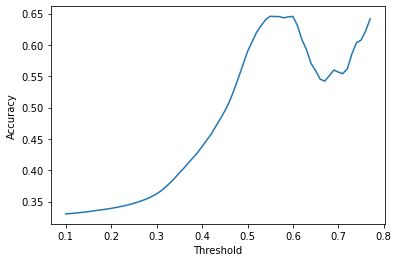

In [116]:
plt.plot(np.arange(0.1,0.78,0.01),res)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.show()

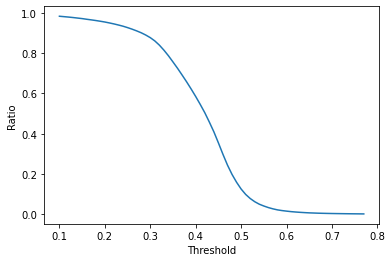

In [117]:
plt.plot(np.arange(0.1,0.78,0.01),res_n)
plt.xlabel("Threshold")
plt.ylabel("Ratio")
plt.show()

In [124]:
pre_ = np.where(pre>0.5,1,0)
pos_res = test_y[np.where(pre_==1)[0]]
print((pos_res==1).sum()/pos_res.shape[0])
print(pos_res.shape[0]/test_y.shape[0])

0.589425587467363
0.125590615730873
